## Background

In this notebook, I will work through the last "Further Research" exercise from Chapter 9 of the fastai textbook:

> Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).

I'll start by pasting the source code of `TabularModel` here:

```python
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self,
        emb_szs:list, # Sequence of (num_embeddings, embedding_dim) for each categorical variable
        n_cont:int, # Number of continuous variables
        out_sz:int, # Number of outputs for final `LinBnDrop` layer
        layers:list, # Sequence of ints used to specify the input and output size of each `LinBnDrop` layer
        ps:float|MutableSequence=None, # Sequence of dropout probabilities for `LinBnDrop`
        embed_p:float=0., # Dropout probability for `Embedding` layer
        y_range=None, # Low and high for `SigmoidRange` activation
        use_bn:bool=True, # Use `BatchNorm1d` in `LinBnDrop` layers
        bn_final:bool=False, # Use `BatchNorm1d` on final layer
        bn_cont:bool=True, # Use `BatchNorm1d` on continuous variables
        act_cls=nn.ReLU(inplace=True), # Activation type for `LinBnDrop` layers
        lin_first:bool=True # Linear layer is first or last in `LinBnDrop` layers
    ):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont = n_emb,n_cont
        sizes = [n_emb + n_cont] + layers + [out_sz]
        actns = [act_cls for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first)
                       for i,(p,a) in enumerate(zip(ps+[0.],actns))]
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)
```

In the sections below, I will walk through each line of code to make sure I understand what it does.

In [1]:
from fastai.tabular.all import *

## `__init__`

The `__init__` method's parameters are well-defined by the comments in the source code so I will not list each of them here. However, in order to run actual code for the rest of the lines, I will assign some test values to each of the parameters. I'll also define `x_cat` and `x_cont` so that we have some fake data to work with. I have set all `BatchNorm1d` and `Dropout` related parameters to `0`, `False`, or `None`.

In [58]:
torch.manual_seed(42);

# self.init parameters
emb_szs = [(4,2), (17,8)]
n_cont = 1
out_sz = 1
layers = [200,100]
ps = None
embed_p = 0.
y_range = (0,1)
use_bn = False
bn_final = False
bn_cont = False
act_cls=nn.ReLU(inplace=True)
lin_first = True

# fake data
x_cat1 = torch.randint(0,4,(10,))
x_cat2 = torch.randint(0,17,(10,))
x_cat = torch.column_stack((x_cat1, x_cat2))
x_cont = torch.randn(10)[:,None]

### `ps`

I am not sure what dropout probabilities do exactly, so I won't explain the code here other than running it as shown in the source code:

In [62]:
ps = ifnone(ps, [0]*len(layers))
if not is_listy(ps): ps = [ps]*len(layers)

In [63]:
ps

[0, 0]

### `self.embeds`

`self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])`

This line of code creates `Embedding`s, one for each tuple defined in `emb_szs`, which in turn is one tuple defined for each categorical variable. In my example, I have two categorical variables so I will create two `Embedding`s.

In [64]:
embeds = nn.ModuleList(Embedding(ni, nf) for ni,nf in emb_szs)
embeds

ModuleList(
  (0): Embedding(4, 2)
  (1): Embedding(17, 8)
)

### `self.emb_drop`

The following line creates an `nn.Dropout` object which will be used in the model. According to the PyTorch website:

> During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

`self.emb_drop = nn.Dropout(embed_p)`

In [96]:
emb_drop = nn.Dropout(embed_p)
emb_drop

Dropout(p=0.0, inplace=False)

### `self.bn_cont`

The following line assigns a `BatchNorm1d` function to `self.bn_cont` if the input argument `bn_cont` is `True`. Since in this case, I have set `bn_cont` to `False`, it would set `self.bn_cont` to `None`:

`self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None`

In [105]:
bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
bn_cont

### `n_emb`

`n_emb = sum(e.embedding_dim for e in self.embeds)`

In my toy example, I have one `Embedding` containing 4 tensors of size 2, and one `Embedding` containing 17 tensors of size 8, so the total size will be 10.

In [65]:
n_emb = sum(e.embedding_dim for e in embeds)
n_emb

10

### `self.n_emb,self.n_cont`

`self.n_emb,self.n_cont = n_emb,n_cont`

This line of code is simply storing the total `Embedding` size and number of continuous variables.

### `sizes`

`sizes = [n_emb + n_cont] + layers + [out_sz]`

This line defines the sizes of the input to the model (which contains `Embeddings` for categorical variables and `n_cont` continuous variables), a number of intermediate `layers`, and a final `out_sz` output size for the output of the model.

In [66]:
sizes = [n_emb + n_cont] + layers + [out_sz]
sizes

[11, 200, 100, 1]

### `actns`

`actns = [act_cls for _ in range(len(sizes)-2)] + [None]`

This line defines the activations for the model for all layers. The final layer does not have an activation function so it is set to `None`.

In [67]:
actns = [act_cls for _ in range(len(sizes)-2)] + [None]
actns

[ReLU(inplace=True), ReLU(inplace=True), None]

### `_layers`

`_layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first) for i,(p,a) in enumerate(zip(ps+[0.],actns))]`

I'll walk through the components of this line, without going into detail about the "why" behind code related to `BatchNorm1d` and `Dropout` layers.

The following code zips together the list of `ps` probabilities and activations `actns`:

In [68]:
list(zip(ps+[0.], actns))

[(0, ReLU(inplace=True)), (0, ReLU(inplace=True)), (0.0, None)]

The following code determines whether the `bn` parameter for `LinBnDrop` is set to `True` or `False`. If `use_bn` is `True`, and either of `i!=len(actns)-1` or `bn_final` are `True` then `bn` will be assigned `True`, otherwise it will be `False`.

Looking at the second condition, `(i!=len(actns)-1 or bn_final)`, in more detail:

If `i!=len(actns)-1` is `True`, it means that the final element of the enumeration has not been reached. In other words, the index does not correspond to the final layer of the model. If it's `False`, that means we have reached the index corresponding to the final layer in the model. In that case, the `or` condition can still result in truth if `bn_final` is `True`.

`bn=use_bn and (i!=len(actns)-1 or bn_final)`

In [71]:
True and (True or False)

True

In [72]:
True and (False or True)

True

The following code generates a `LinBnDrop` layer for each activation function, setting the inputs and outputs of the layer based on the values in the `sizes` list:

In [69]:
_layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a,
                     lin_first=lin_first) for i, (p,a) in enumerate(zip(ps+[0.], actns))]

_layers

[LinBnDrop(
   (0): Linear(in_features=11, out_features=200, bias=True)
   (1): ReLU(inplace=True)
 ),
 LinBnDrop(
   (0): Linear(in_features=200, out_features=100, bias=True)
   (1): ReLU(inplace=True)
 ),
 LinBnDrop(
   (0): Linear(in_features=100, out_features=1, bias=True)
 )]

### `y_range`

`if y_range is not None: _layers.append(SigmoidRange(*y_range))`

This line of code adds on a `SigmoidRange` function which limits the output values to the values defined in `y_range`.

Here is what the function `SigmoidRange(0,1)` looks like for input values between -10 and 10:

In [80]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

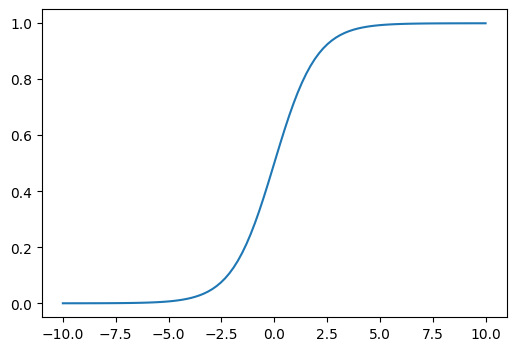

In [82]:
plot_function(SigmoidRange(0,1), min=-10, max=10)

In [83]:
if y_range is not None: _layers.append(SigmoidRange(*y_range))

In [84]:
_layers

[LinBnDrop(
   (0): Linear(in_features=11, out_features=200, bias=True)
   (1): ReLU(inplace=True)
 ),
 LinBnDrop(
   (0): Linear(in_features=200, out_features=100, bias=True)
   (1): ReLU(inplace=True)
 ),
 LinBnDrop(
   (0): Linear(in_features=100, out_features=1, bias=True)
 ),
 fastai.layers.SigmoidRange(low=0, high=1)]

### `self.layers`

`self.layers = nn.Sequential(*_layers)`

The final piece to handling the layers in the model is to wrap them in a `nn.Sequential` model, so that inputs are passed sequentially to each layer in the list `_layers`.

In [85]:
layers = nn.Sequential(*_layers)
layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=11, out_features=200, bias=True)
    (1): ReLU(inplace=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=100, out_features=1, bias=True)
  )
  (3): fastai.layers.SigmoidRange(low=0, high=1)
)

## `forward`

### `if self.n_emb != 0:`

In this example, `n_emb` is not equal to 0 so the following code will run.

`x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]`

In this line of code, the categorical variable columns are passed to the corresponding `Embedding` and the output tensor is stored in a list.

In [91]:
x = [e(x_cat[:,i]) for i,e in enumerate(embeds)]
len(x), len(x[0]), len(x[1])

(2, 10, 10)

There are 10 rows in `x_cat`. The `Embedding` corresponding to the first column outputs 2 columns of tensors, and the `Embedding` corresponding to the second column outputs 8 columns of tensors.

In [94]:
x[0].shape

torch.Size([10, 2])

In [95]:
x[1].shape

torch.Size([10, 8])

The following line takes the list of tensors `x` (with a 10 x 2 and 10 x 8 tensor) and concatenates them into a single 10 x 10 tensor.

`x = torch.cat(x, 1)`

In [ ]:
x = torch.cat(x,1)

In [100]:
x.shape

torch.Size([10, 10])

In [102]:
x

tensor([[ 1.3314e-03,  8.6398e-03,  2.0744e-04,  2.5392e-03,  9.3644e-03,
          7.1224e-03, -3.1766e-04,  1.0164e-03,  1.3433e-02,  7.1327e-03],
        [-1.0157e-02, -8.8875e-03, -1.5988e-02, -1.0913e-03,  7.1520e-03,
          3.9139e-04,  1.3059e-02,  2.4659e-03, -1.9776e-02,  1.7896e-04],
        [-4.9903e-04,  5.2634e-03,  3.7818e-03,  7.0511e-03, -1.7237e-02,
         -8.4348e-03,  4.3514e-03,  2.6589e-03, -5.8710e-03,  8.2689e-04],
        [ 1.3314e-03,  8.6398e-03, -1.5988e-02, -1.0913e-03,  7.1520e-03,
          3.9139e-04,  1.3059e-02,  2.4659e-03, -1.9776e-02,  1.7896e-04],
        [ 1.3314e-03,  8.6398e-03, -7.1988e-04, -9.0609e-03, -4.8712e-04,
         -1.0811e-02,  1.7623e-04,  7.8226e-04,  1.9316e-03,  4.0967e-03],
        [-1.0157e-02, -8.8875e-03,  1.2554e-02, -7.1496e-03,  8.5392e-03,
          5.1299e-03,  5.3973e-03,  5.6551e-03,  5.0579e-03,  2.2245e-03],
        [-4.9903e-04,  5.2634e-03, -6.8548e-03,  5.6356e-03, -1.5072e-02,
         -1.6107e-02, -1.4790e-0

The following line of code passes the `x` tensor through the `nn.Dropout` function. If I understand correctly, since I defined `embed_p` as 0, passing it through the `Dropout` layer will not affect the tensor `x`.

`x = self.emb_drop(x)`

In [103]:
x = emb_drop(x)

### `if self.n_cont != 0`

In this example, `n_cont` is not 0 so the following code will run.

Since `bn_cont` is `None`, the code `x_cont = self.bn_cont(x_cont)` will not run.

`if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)`

In [106]:
if bn_cont is not None: x_cont = bn_cont(x_cont)

In the following line, if `n_emb` is not 0, it will concatenate `x` (which holds the outputs of the categorical `Embedding`s) with `x_cont` (which holds the continuous variable columns) into a single tensor. If `n_emb` is 0, it will assign `x_cont` to `x`.

In this example, `n_emb` is not 0 so it will concatenate `x` with `x_cont`.

`x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont`

In [107]:
x.shape

torch.Size([10, 10])

In [119]:
x = torch.cat([x, x_cont], 1) if n_emb != 0 else x_cont

The concatenation has added a column of tensors (continuous variable) to `x`:

In [120]:
x.shape

torch.Size([10, 11])

### `return`

The final piece of the `forward` method is to return the outputs of the model. This is done by passing our 11 inputs in `x` (10 categorical embeddings, 1 continuous variable) to the `layers` `nn.Sequential` model defined before.

`self.layers(x)`

In [121]:
layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=11, out_features=200, bias=True)
    (1): ReLU(inplace=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=100, out_features=1, bias=True)
  )
  (3): fastai.layers.SigmoidRange(low=0, high=1)
)

The output is a tensor with 10 values, 1 for each of the 10 input rows.

In [122]:
layers(x)

tensor([[0.5217],
        [0.5210],
        [0.5216],
        [0.5214],
        [0.5149],
        [0.5192],
        [0.5377],
        [0.5174],
        [0.5223],
        [0.5221]], grad_fn=<AddBackward0>)

## Final Thoughts

I _**really**_ enjoyed this exercise and will definitely apply the same process of running line-by-line code in the future when I am trying to understand fastai (or other) library source code. By the end of this exercise, I was surprised at how simple and straightforward it is to build a `TabularModel` object. It's so powerful given its simplicity.

I hope you enjoyed this blog post!